In [101]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [102]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [103]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [104]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [105]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

In [106]:
from langchain_core.messages import HumanMessage
from langchain_core.messages import AIMessage, ToolMessage

In [107]:
from langchain_openai import ChatOpenAI

In [108]:
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import pretty_print_messages
from langchain_teddynote.messages import display_message_tree
from langchain_core.runnables import RunnableConfig
import json

In [109]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, 'dummy']

In [110]:
######### 2. 도구 정의 및 바인딩 #########

@tool
def search_keyword(query: str) -> List[Dict[str, str]]:     # 키워드로 뉴스 검색하는 도구     
    """Look up news by keyword"""

    news_tool = GoogleNews()        
    return news_tool.search_by_keyword(query, k=1)


tools = [search_keyword]

In [111]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

llm_with_tools = llm.bind_tools(tools)

In [112]:
def chatbot(state: State):
    print('===== chatbot() 함수 시작 =====')
    
    print("[1] chatbot() 으로 넘어온 메시지: ")
    print(state)
    message_type1 = ''

    for msg in state['messages']:
        if isinstance(msg, HumanMessage):
            message_type1 = message_type1 + '[HumanMessage]'
        elif isinstance(msg, AIMessage):
            message_type1 = message_type1 + '[AIMessage]'
        elif isinstance(msg, ToolMessage):
            message_type1 = message_type1 + '[ToolMessage]'
        
        print(f'메시지 타입: {message_type1}')
        print(msg)
        print()

    print(f"\n[2] 메시지 개수 : {len(state['messages'])}\n")

    answer = llm_with_tools.invoke(state['messages'])

    # print(f'[도구 사용 LLM 실행 결과 content]: {answer.content}')
    
    print('[3] chatbot()에서 실행:')
    print('메시지 타입: ', end='')

    message_type2 = ''
    if isinstance(answer, AIMessage):
        message_type2 = message_type2 + '[AIMessage]'
    elif isinstance(answer, HumanMessage):
        message_type2 = message_type2 + '[HumanMessage]'
    elif isinstance(answer, ToolMessage):
        message_type2 = message_type2 + '[ToolMessage]'
    else:
        message_type2 = type(answer)

    print(message_type2)
    print(answer)
    print()

    answer_value = {'messages': [answer]}

    print(f"[4] chatbot()에서 실행 후 메시지 개수: {message_type1} {message_type2} {len(state['messages']) + len(answer_value)}") 
    print('===== chatbot() 함수  끝 =====')
    print()

    return answer_value

In [113]:
# 상태 그래프 생성
graph_builder = StateGraph(State)

In [114]:
# chatbot 노드 추가
graph_builder.add_node('chatbot', chatbot)

In [115]:
# 도구 노드 생성
tool_node = ToolNode(tools=[search_keyword])

In [116]:
# 도구 노드 추가
graph_builder.add_node('tools', tool_node)

In [117]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [118]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [119]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [120]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [121]:
######### 6. 메모리 생성 #######

from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [122]:
######### 7. 그래프 컴파일 #######

graph = graph_builder.compile(checkpointer=memory)

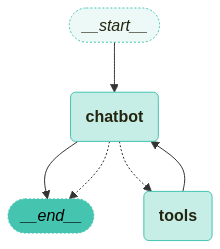

In [123]:
######### 8. 그래프 #######

visualize_graph(graph)

In [131]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id},
    tags=['data-tag']
)

question = '연금개혁'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)


i = 1

for event in graph.stream(input=input, config=config, output_keys=["dummy_data", 'messages'], stream_mode='values'):
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작 ({i})')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print(f'해당 노드 값: \n')
        print(value)
        
        if value and "dummy_data" in value:
            print('더미 데이터: ')
            print(value["dummy_data"])
        
        if value and 'messages' in value:
            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")
                print('==================== END HumanMessage ====================')            
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")

                if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = value['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')                
                print('==================== END AIMessage ====================')
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

                content = json.loads(value['messages'][-1].content)

                if content and isinstance(content, list) and len(content) > 0:                
                    print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                    print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                    print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
                else:
                    print("No content or invalid content format in ToolMessage")

                print('==================== END ToolMessage ====================')


    i=i+1

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

print(f'전체 반복문 {i-1}번 실행')  

thread_id: 5428e1

========================= 여기서 시작 ====================
[event] 바깥 for 시작 (1)

실행한 노드 이름: dummy_data
해당 노드 값: 

테스트 문자열
실행한 노드 이름: messages
해당 노드 값: 

[HumanMessage(content='연금개혁', additional_kwargs={}, response_metadata={}, id='b39076fa-2f91-47cb-8a9f-ef1ea46b53eb')]
바깥 for 끝
========================= 여기서 끝 =========================

===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
{'messages': [HumanMessage(content='연금개혁', additional_kwargs={}, response_metadata={}, id='b39076fa-2f91-47cb-8a9f-ef1ea46b53eb')], 'dummy_data': '테스트 문자열'}
메시지 타입: [HumanMessage]
content='연금개혁' additional_kwargs={} response_metadata={} id='b39076fa-2f91-47cb-8a9f-ef1ea46b53eb'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_54F4qKFJumfgInMs6LvIIfdJ', 'function': {'arguments': '{"query":"연금개혁"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 1

In [132]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id},
    tags=['data-tag']
)

question = '2024년 노벨 문학상 관련 뉴스를 알려주세요.'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)

for event in graph.stream(input=input, config=config):      # 모드에 따라 event가 딕셔너리 또는 리스트. 기본 모드는 evenv가 딕셔서리 이다.
    for key, value in event.items():
        print(f'\n{key}\n')                                 # key 에는 노드의 이름

        if 'messages' in value:                             # value에는 해당 노드의 값
            message = value['messages']
            value['messages'][-1].pretty_print()

thread_id: ffccda
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
{'messages': [HumanMessage(content='2024년 노벨 문학상 관련 뉴스를 알려주세요.', additional_kwargs={}, response_metadata={}, id='105a8cbb-16c9-45c1-b092-497701dc5ad7')], 'dummy_data': '테스트 문자열'}
메시지 타입: [HumanMessage]
content='2024년 노벨 문학상 관련 뉴스를 알려주세요.' additional_kwargs={} response_metadata={} id='105a8cbb-16c9-45c1-b092-497701dc5ad7'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_RxjsfWrZtfLhDN9LkRMDbtXA', 'function': {'arguments': '{"query":"2024 Nobel Prize in Literature"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 57, 'total_tokens': 77, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'g

In [133]:
list(graph.channels.keys())

['messages',
 'dummy_data',
 '__start__',
 'chatbot',
 'tools',
 'branch:__start__:__self__:chatbot',
 'branch:__start__:__self__:tools',
 'branch:chatbot:__self__:chatbot',
 'branch:chatbot:__self__:tools',
 'branch:tools:__self__:chatbot',
 'branch:tools:__self__:tools',
 'start:chatbot',
 'branch:chatbot:tools_condition:tools']

In [ ]:
from langchain_teddynote.graphs import generate_random_hash
from langchain_core.runnables import RunnableConfig

thread_id = generate_random_hash()
print(f"thread_id: {thread_id}")

config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': thread_id},
    tags=['data-tag']
)

question = '연금개혁'

input = State(
    dummy_data='테스트 문자열' ,
    messages=[('user', question)]
)


i = 1

for event in graph.stream(input=input, config=config, output_keys=["dummy_data", 'messages'], stream_mode='updates'):
    print()
    print('========================= 여기서 시작 ====================')
    print(f'[event] 바깥 for 시작 ({i})')
    print()

    for k, value in event.items():
        print(f'실행한 노드 이름: {k}')
        print(f'해당 노드 값: \n')
        print(value)
        
        if value and "dummy_data" in value:
            print('더미 데이터: ')
            print(value["dummy_data"])
        
        if value and 'messages' in value:

            if isinstance(value['messages'][-1], HumanMessage):
                print('==================== HumanMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")
                print('==================== END HumanMessage ====================')            
            elif isinstance(value['messages'][-1], AIMessage):
                print('==================== AIMessage ========================')
                print(f"[해당 노드 값] content: {value['messages'][-1].content}")

                if hasattr(value['messages'][-1], 'tool_calls') and len(value['messages'][-1].tool_calls) > 0:
                    print('tool call 있음')
                    tool_result = value['messages'][-1].tool_calls
                    print(f"도구 이름 : {tool_result[0]['name']}")
                    print(f"도구 인자: {tool_result[0]['args']}")            
                else:
                    print('tool call 없음')                
                print('==================== END AIMessage ====================')
            elif isinstance(value['messages'][-1], ToolMessage):
                print('==================== ToolMessage ========================')
                print(f"[해당 노드 값] 도구 도구 이름 : {value['messages'][-1].name}")

                content = json.loads(value['messages'][-1].content)

                if content and isinstance(content, list) and len(content) > 0:                
                    print(f"[해당 노드 값] 제목: {content[0].get('title', 'No title')}")
                    print(f"[해당 노드 값] URL: {content[0].get('url', 'No URL')}")
                    print(f"[해당 노드 값] 내용: {content[0].get('content', 'No URL')}")                
                else:
                    print("No content or invalid content format in ToolMessage")

                print('==================== END ToolMessage ====================')


    i=i+1

    print('바깥 for 끝')
    print('========================= 여기서 끝 =========================') 
    print()

print(f'전체 반복문 {i-1}번 실행')  

thread_id: 741fde
===== chatbot() 함수 시작 =====
[1] chatbot() 으로 넘어온 메시지: 
{'messages': [HumanMessage(content='연금개혁', additional_kwargs={}, response_metadata={}, id='323cebe0-a190-4279-9110-d3114beb257d')], 'dummy_data': '테스트 문자열'}
메시지 타입: [HumanMessage]
content='연금개혁' additional_kwargs={} response_metadata={} id='323cebe0-a190-4279-9110-d3114beb257d'


[2] 메시지 개수 : 1

[3] chatbot()에서 실행:
메시지 타입: [AIMessage]
content='' additional_kwargs={'tool_calls': [{'id': 'call_ZWL1oioga77JdJWcnWMCEvWX', 'function': {'arguments': '{"query":"연금개혁"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 47, 'total_tokens': 65, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b8bc95a0ac', 'finish